In [3]:
from BPNN_DATA_Reg_HR import model_data as R_data
import numpy as np
import tensorflow as tf
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题

['营业部' '营业站' '营业点' '集收客户营业部']
['福田区' '宝安区' '坪山区' '龙岗区' '南山区' '罗湖区' '龙华区' '光明区' '光明新区' '大鹏新区' '盐田区'
 '龙华新区' '坪山新区']


/Users/rhyme/Desktop/SFTech/BPNN_Regression/BPNN_DATA_Reg_HR.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['t1.accumulate_tickets'] = df3['t1.accumulate_tickets'] - df3['t1.tickets']


In [4]:
'''第一部分：数据准备'''
train_x_data = R_data[0]
train_y_data = R_data[1]
predict_x_data=R_data[2]
predict_y_data=R_data[3]

In [9]:
#-*- coding：utf-8 -*-
# &Author  AnFany

# 适用于多维输出
from BPNN_DATA_Reg import model_data as R_data
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


'''第一部分：数据准备'''
train_x_data = R_data[0]  # 训练输入
train_y_data = R_data[1]  # 训练输出

predict_x_data = R_data[2]  # 测试输入
predict_y_data = R_data[3]  # 测试输出

'''第二部分： 基于TensorFlow构建训练函数'''
# 创建激活函数
def activate(input_layer, weights, biases, actfunc):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    if actfunc == 'relu':
        return tf.nn.relu(layer)
    elif actfunc == 'tanh':
        return tf.nn.tanh(layer)
    elif actfunc == 'sigmoid':
        return tf.nn.sigmoid(layer)
# 权重初始化的方式和利用激活函数的关系很大
# sigmoid: xavir  tanh: xavir    relu: he

#  构建训练函数
def Ten_train(xdata, ydata, prexdata, hiddenlayers=3, hiddennodes=100, \
              learn_rate=0.05, itertimes=100000, batch_size=200, activate_func='sigmoid', break_error=0.0043):
    # 开始搭建神经网络
    Input_Dimen = len(xdata[0])
    Unit_Layers = [Input_Dimen] + [hiddennodes] * hiddenlayers + [len(ydata[0])]  # 输入的维数，隐层的神经数，输出的维数1

    # 创建占位符
    x_data = tf.placeholder(shape=[None, Input_Dimen], dtype=tf.float32)
    y_target = tf.placeholder(shape=[None, len(ydata[0])], dtype=tf.float32)

    # 实现动态命名变量
    VAR_NAME = locals()

    for jj in range(hiddenlayers + 1):
        VAR_NAME['weight%s' % jj] = tf.Variable(np.random.rand(Unit_Layers[jj], Unit_Layers[jj + 1]), dtype=tf.float32,\
                                                name='weight%s' % jj) / np.sqrt(Unit_Layers[jj])  # sigmoid  tanh
        # VAR_NAME['weight%s'%jj] = tf.Variable(np.random.rand(Unit_Layers[jj], Unit_Layers[jj + 1]), dtype=tf.float32,name='weight%s' % jj) \/ np.sqrt(Unit_Layers[jj] / 2)  # relu
        VAR_NAME['bias%s' % jj] = tf.Variable(tf.random_normal([Unit_Layers[jj + 1]], stddev=10, name='bias%s' % jj),
                                              dtype=tf.float32)
        if jj == 0:
            VAR_NAME['ooutda%s' % jj] = activate(x_data, eval('weight%s' % jj), eval('bias%s' % jj), actfunc=activate_func)
        else:
            VAR_NAME['ooutda%s' % jj] = activate(eval('ooutda%s' % (jj - 1)), eval('weight%s' % jj), \
                                                 eval('bias%s' % jj), actfunc=activate_func)

    # 均方误差
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(y_target - eval('ooutda%s' % (hiddenlayers))), reduction_indices=[1]))

    # 优化的方法
    my_opt = tf.train.AdamOptimizer(learn_rate)
    train_step = my_opt.minimize(loss)

    # 初始化
    init = tf.global_variables_initializer()

    loss_vec = []  # 训练误差

    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(init)
        for i in range(itertimes):
            rand_index = np.random.choice(len(xdata), size=batch_size, replace=False)
            rand_x = xdata[rand_index]
            rand_y = ydata[rand_index]

            sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

            temp_loss = sess.run(loss, feed_dict={x_data: xdata, y_target: ydata})

            loss_vec.append(temp_loss)

            # 根据输出的误差，判断训练的情况
            if (i + 1) % 25 == 0:
                print('Generation: ' + str(i + 1) + '. 归一误差：Loss = ' + str(temp_loss))

            # 提前退出的判断
            if temp_loss < break_error:  # 根据经验获得此数值, 因为采用的是随机下降，因此误差在前期可能出现浮动
                break

        # 计算预测数据的输出
        pre_in_data0 = np.array(prexdata, dtype=np.float32)
        for ipre in range(hiddenlayers + 1):
            VAR_NAME['pre_in_data%s' % (ipre + 1)] = activate(eval('pre_in_data%s' % ipre), eval('weight%s' % ipre).eval(),\
                                                                 eval('bias%s' % ipre).eval(), actfunc=activate_func)

        # 计算训练数据的输出
        train_in_data0 = np.array(xdata, dtype=np.float32)
        for ipre in range(hiddenlayers + 1):
            VAR_NAME['train_in_data%s' % (ipre + 1)] = activate(eval('train_in_data%s' % ipre), eval('weight%s' % ipre).eval(),\
                                                                 eval('bias%s' % ipre).eval(), actfunc=activate_func)

        return eval('train_in_data%s'%(hiddenlayers+1)).eval(), eval('pre_in_data%s'%(hiddenlayers+1)).eval(), loss_vec

'''第三部分： 结果展示函数'''

import matplotlib.pyplot as plt
from pylab import mpl  # 作图显示中文
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 设置中文字体新宋体
#  绘制图像
def figure(real, net, le='训练', real_line='ko-', net_line='r.-', width=3):
    length = len(real[0])
    # 绘制每个维度的对比图
    for iwe in range(length):
        plt.subplot(length, 1, iwe+1)
        plt.plot(list(range(len(real.T[iwe]))), real.T[iwe], real_line, linewidth=width)
        plt.plot(list(range(len(net.T[iwe]))), net.T[iwe], net_line, linewidth=width - 1)
        plt.legend(['%s真实值'%le, '网络输出值'])
        if length == 1:
            plt.title('%s结果对比'%le)
        else:
            if iwe == 0:
                plt.title('%s结果: %s维度对比'%(le, iwe))
            else:
                plt.title('%s维度对比'%iwe)
    plt.show()

# 绘制成本函数曲线图
def costfig(errlist, le='成本函数曲线图'):
    plt.plot(list(range(len(errlist))), errlist, linewidth=3)
    plt.title(le)
    plt.xlabel('迭代次数')
    plt.ylabel('成本函数值')
    plt.show()

#  因为训练数据较多，为了不影响展示效果，按序随机选取一定数量的数据，便于展示
def select(datax, datay, count=200):
    sign = list(range(len(datax)))
    selectr_sign = np.random.choice(sign, count, replace=False)
    return datax[selectr_sign], datay[selectr_sign]

# 将输出的数据转换尺寸，变为原始数据的尺寸
def trans(ydata, minumber=R_data[4][0], maxumber=R_data[4][1]):
    return ydata * (maxumber - minumber) + minumber


if __name__ == '__main__':
    #  训练
    tfrelu = Ten_train(train_x_data, train_y_data, predict_x_data)


    #  真实的数据转换尺寸
    train_y_data_tran = trans(train_y_data)
    predict_y_data_tran = trans(predict_y_data)


    #  网络预测的数据转换尺寸
    train_output = trans(tfrelu[0])
    predict_output = trans(tfrelu[1])

    # 数据多影响展示，随机挑选100条数据
    random_train_x_data = select(train_output, train_y_data_tran, 200)
    random_predict_x_data = select(predict_output, predict_y_data_tran, 100)


    figure(random_train_x_data[1], random_train_x_data[0], le='训练')

    figure(random_predict_x_data[1], random_predict_x_data[0], le='预测')

    costfig(tfrelu[2])





Instructions for updating:
non-resource variables are not supported in the long term
Generation: 25. 归一误差：Loss = 0.008566342
Generation: 50. 归一误差：Loss = 0.008553199
Generation: 75. 归一误差：Loss = 0.008258431
Generation: 100. 归一误差：Loss = 0.0073960074
Generation: 125. 归一误差：Loss = 0.006507441
Generation: 150. 归一误差：Loss = 0.0057129073
Generation: 175. 归一误差：Loss = 0.005800006
Generation: 200. 归一误差：Loss = 0.005553886
Generation: 225. 归一误差：Loss = 0.0054031773
Generation: 250. 归一误差：Loss = 0.005324003
Generation: 275. 归一误差：Loss = 0.0053642876
Generation: 300. 归一误差：Loss = 0.00558937
Generation: 325. 归一误差：Loss = 0.0053187283
Generation: 350. 归一误差：Loss = 0.005326105
Generation: 375. 归一误差：Loss = 0.0062842187
Generation: 400. 归一误差：Loss = 0.0051321834
Generation: 425. 归一误差：Loss = 0.0050952495
Generation: 450. 归一误差：Loss = 0.0053585293
Generation: 475. 归一误差：Loss = 0.005071229
Generation: 500. 归一误差：Loss = 0.004914353
Generation: 525. 归一误差：Loss = 0.004889801
Generation: 550. 归一误差：Loss = 0.004849162
Generati

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

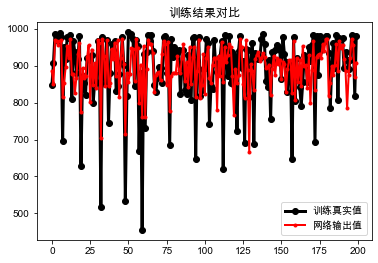

In [15]:
figure(random_train_x_data[1], random_train_x_data[0], le='训练')

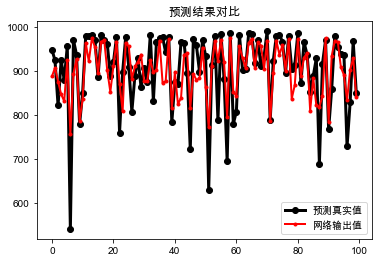

In [16]:
figure(random_predict_x_data[1], random_predict_x_data[0], le='预测')

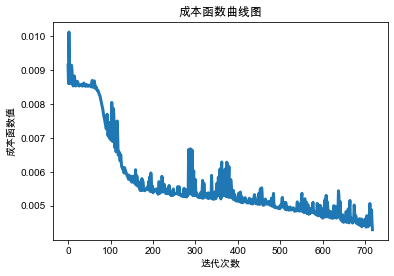

In [17]:
costfig(tfrelu[2])